In [1]:
from bs4 import BeautifulSoup
import requests
import time
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import geopandas

# Scraping

In [ ]:
main_url="https://stadiumdb.com/stadiums"
html=requests.get(main_url,headers).content
soup=BeautifulSoup(html)

In [ ]:
country_urls=[e['href'] for e in soup.select('ul[class=x] li a')]


all_stadium_urls=[]
for i, country_url in enumerate(country_urls,start=1):
    html=requests.get(country_url,headers).content
    soup=BeautifulSoup(html)

    stadium_urls=[e['href'] for e in soup.select('table[class=x] tr a')]
    all_stadium_urls.extend(stadium_urls)

    print(f'{i}/{len(country_urls)}',end='\r')

In [ ]:
all_stadium_urls=list(set(all_stadium_urls))
len(all_stadium_urls)

In [ ]:
def return_dict(url):
    try:
        html=requests.get(url, headers).content
        soup=BeautifulSoup(html)

        name=soup.select_one('h1[class="icon i-stadium"]').text
        info_dict={tr.select_one('th').text:tr.select_one('td').text for tr in soup.select('table[x] tr')}
        info_dict['Name']=name
        info_dict['URL']=url
    except:
        info_dict=None

    return info_dict



In [ ]:
all_data=[]

for i, stadium_url in enumerate(all_stadium_urls,start=1):

    info_dict=return_dict(stadium_url)
    all_data.append(info_dict)
    print(f'{i}/{len(all_stadium_urls)}',end='\r')

In [ ]:
scraped_urls=[i['URL'] for i in all_data if i is not None]
remaining_urls=[i for i in scraped_urls if i not in all_stadium_urls]


In [ ]:
for i, stadium_url in enumerate(remaining_urls,start=1):

    info_dict=return_dict(stadium_url)
    all_data.append(info_dict)
    print(f'{i}/{len(remaining_urls)}',end='\r')

In [ ]:
all_data=[i for i in all_data if i is not None]

df=pd.DataFrame(all_data)

# Cleaning

In [ ]:
#df.to_csv('stadiums.csv',index=False)
df=pd.read_csv('stadiums.csv')

In [ ]:
nan_columns=df.columns[df.isna().mean()>=0.9]
df=df.drop(columns=nan_columns)

In [ ]:
df=df.drop(columns=['Other names','Record attendance','','Floodlights', 'Contractor', 'Design','Unnamed: 16', 'Cost', 'URL'],errors='ignore')

In [ ]:
for col in df.columns:
    df[col]=df[col].str.replace('\n','')

In [ ]:
df['Inauguration']=df['Inauguration'].apply(lambda x:x.split('(')[0].strip() if isinstance(x,str) else None).apply(pd.to_datetime,errors='coerce')

In [ ]:
construction_start=df['Construction'].apply(lambda x:x.split('-')[0].split('–')[0].split('/')[-1].split('.')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')
construction_end=df['Construction'].apply(lambda x:x.split('-')[-1].split('–')[-1].split('/')[-1].split('.')[-1] if isinstance(x,str) else None).apply(pd.to_numeric,errors='coerce')

df.insert(df.columns.get_loc('Construction')+1, 'Construction Start Year',construction_start)
df.insert(df.columns.get_loc('Construction')+2, 'Construction End Year',construction_end)

df=df.drop(columns='Construction')

In [ ]:
df['Renovations']=df['Renovations'].apply(lambda x:True if isinstance(x,str) else False)

In [ ]:
df['Capacity']=df['Capacity'].apply(lambda x:x.replace(' ','')).apply(pd.to_numeric)

In [ ]:
df=df[['Name', 'Capacity', 'Country', 'City', 'Address', 'Clubs', 'Construction Start Year', 'Construction End Year','Renovations']]

# EDA

In [2]:
df=pd.read_csv('stadiums.csv')

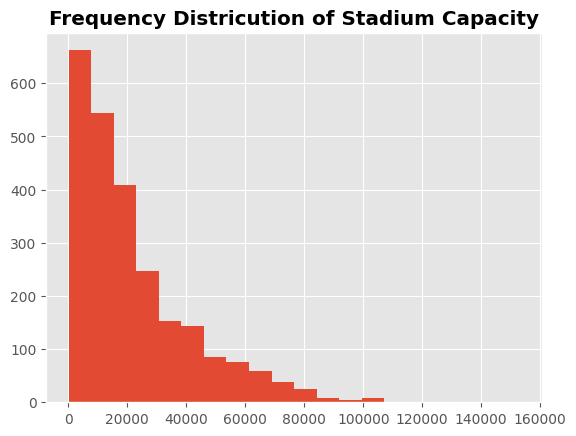

In [3]:
df['Capacity'].hist(bins=20)
plt.title('Frequency Districution of Stadium Capacity',fontweight='bold')
plt.show()

In [4]:
from geopy.geocoders import Nominatim
import time

def get_country_lat_lon(country_name):
    geolocator = Nominatim(user_agent="your_unique_app_name")
    location = geolocator.geocode(country_name)
    if location:
        return location.latitude, location.longitude
    return None, None

coord_dict = {}
for i, country in enumerate(df['Country'].unique(), start=1):
    time.sleep(1)  # Prevents being blocked by Nominatim
    lat, lon = get_country_lat_lon(country)
    coord_dict[country] = {'Lat': lat, 'Lon': lon}

    print(f"Processed: {i}/{df['Country'].nunique()}", end='\r')


In [16]:
grouped=df.groupby('Country').agg({'Name':'count','Capacity':'median'}).reset_index()

grouped['Lat']=grouped['Country'].apply(lambda x:coord_dict.get(x,None).get('Lat',None))
grouped['Lon']=grouped['Country'].apply(lambda x:coord_dict.get(x,None).get('Lon',None))
grouped['Country']=grouped['Country'].str.strip()
grouped=grouped[grouped['Country'].isin(['Georgia','Jordan','Lebanon'])==False]


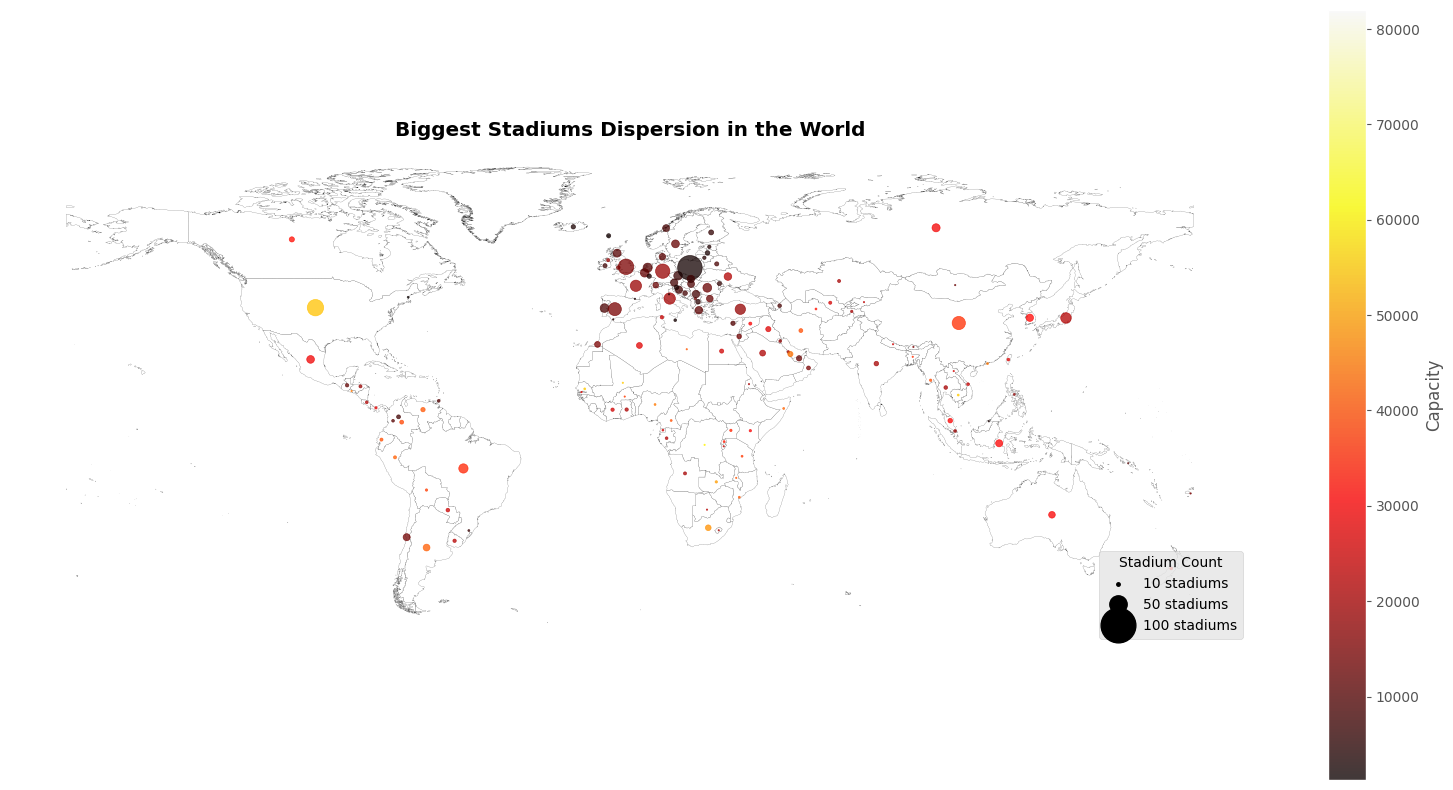

In [24]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import geopandas as gpd

world = gpd.read_file('geopandas/world-administrative-boundaries (detailed)/world-administrative-boundaries.shp')

fig, ax = plt.subplots(figsize=(20, 10))

world.plot(ax=ax, lw=0.1, edgecolor='black', color='white')

scatter = grouped.plot.scatter(ax=ax, x='Lon', y='Lat', s='Name', c='Capacity', cmap='hot', alpha=0.75)

plt.title('Stadiums Dispersion in the World', fontweight='bold')

ax.axis('off')

size_legend = [10, 50, 100]
legend_handles = [mlines.Line2D([], [], linestyle='None', marker='o', markersize=s/4, color='black', label=f'{s} stadiums') for s in size_legend]
ax.legend(handles=legend_handles, loc='lower right', title="Stadium Count")

plt.show()


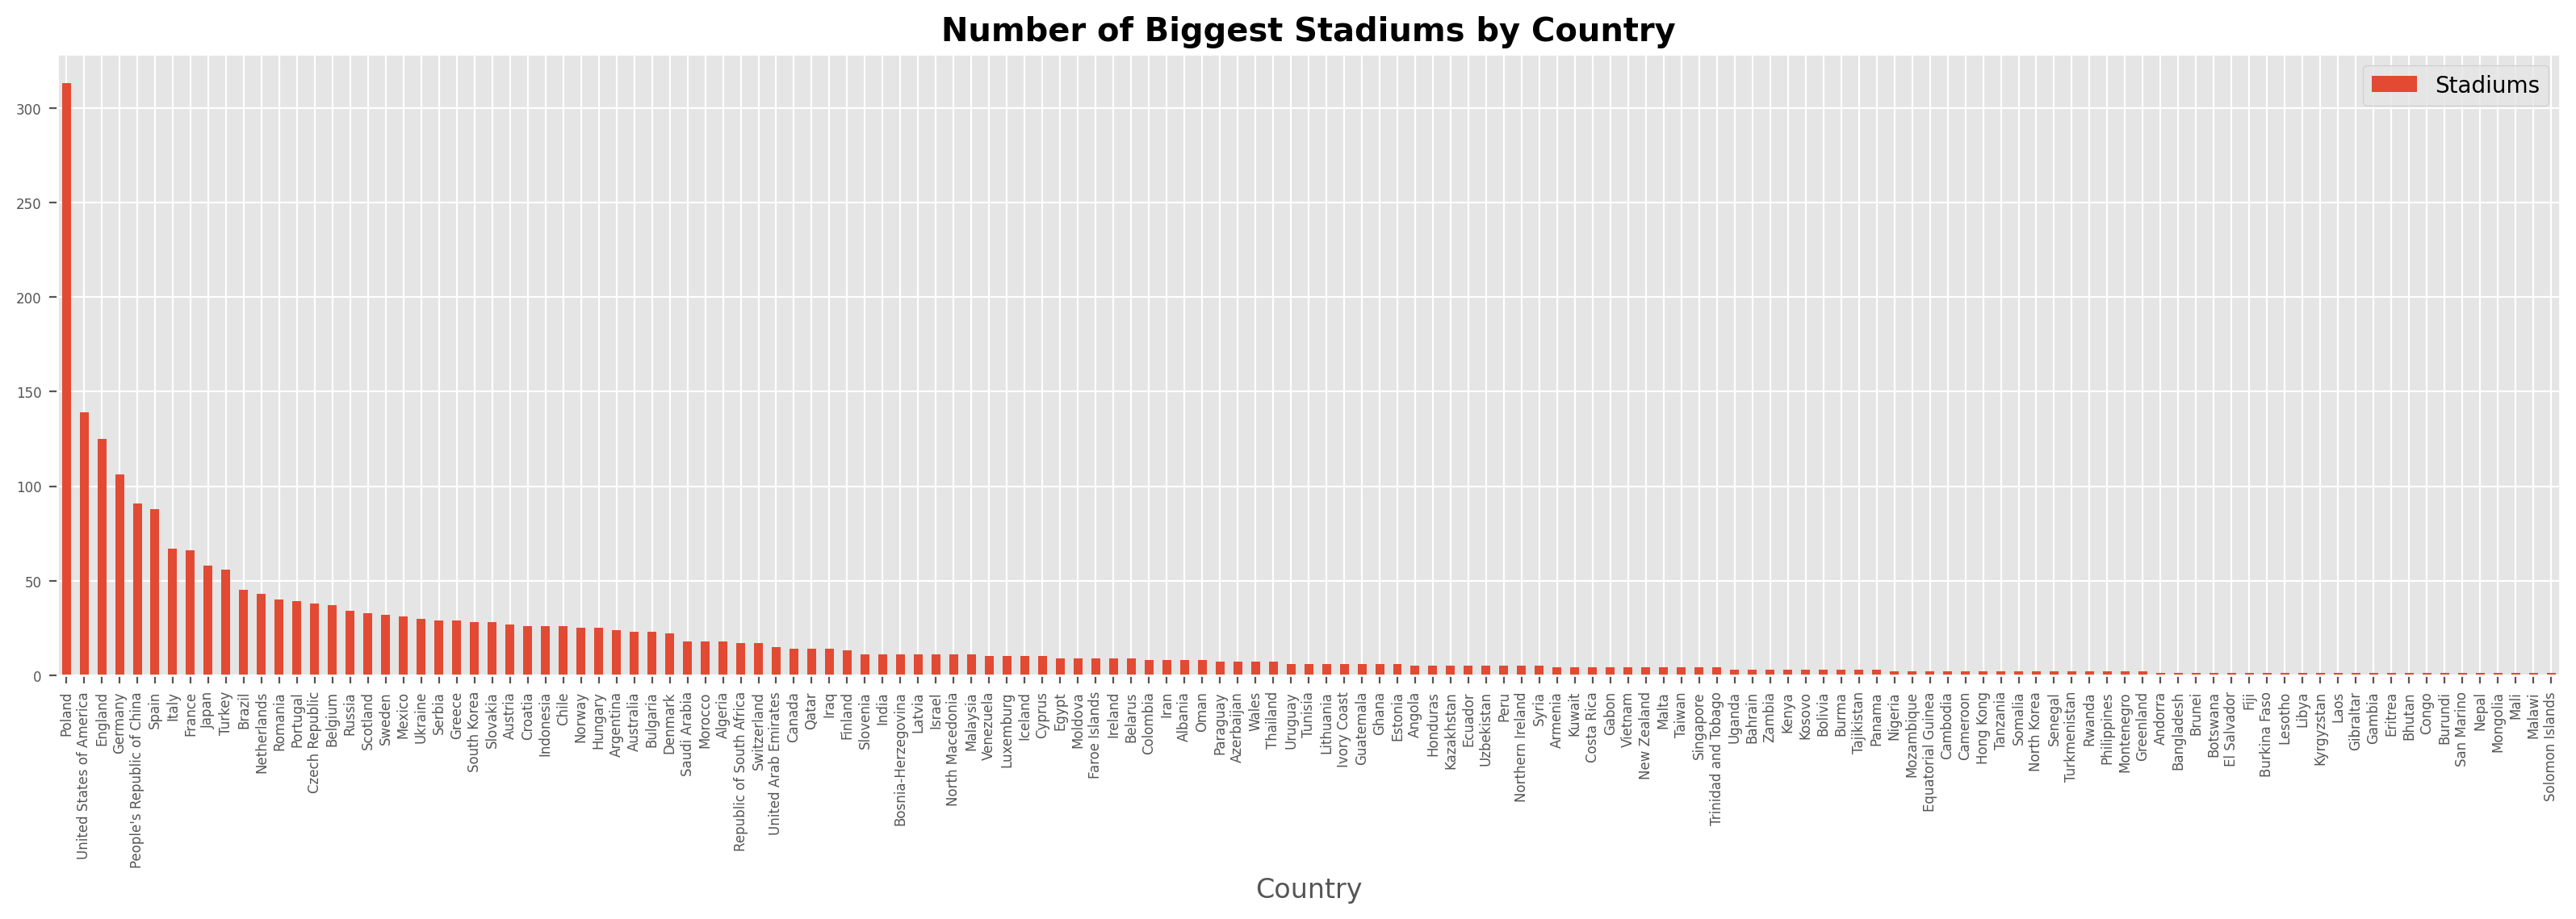

In [22]:
fig,ax=plt.subplots(figsize=(20,5),dpi=200)

grouped.sort_values('Name',ascending=False).plot.bar(ax=ax,x='Country',y='Name',fontsize=6,label='Stadiums')
ax.set_title('Number of Biggest Stadiums by Country',fontweight='bold')
ax.legend()
plt.show()